In [2]:
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.datasets import load_diabetes, load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
class Mydataset(Dataset):

    # Initialization
    def __init__(self, data, label, mode='2D'):
        self.data, self.label, self.mode = data, label, mode

    # Get item
    def __getitem__(self, index):
        if self.mode == '2D':
            return self.data[index, :], self.label[index, :]
        elif self.mode == '3D':
            return self.data[:, index, :], self.label[:, index, :]

    # Get length
    def __len__(self):
        if self.mode == '2D':
            return self.data.shape[0]
        elif self.mode == '3D':
            return self.data.shape[1]

In [4]:
class TemporalLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim):
        super(TemporalLSTM, self).__init__()

        # 超参数继承
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len

        # 注意力的参数
        self.Wa = nn.Parameter(torch.Tensor(input_dim, seq_len), requires_grad=True)
        self.Ua = nn.Parameter(torch.Tensor(hidden_dim , seq_len), requires_grad=True)
        self.ba = nn.Parameter(torch.Tensor(seq_len), requires_grad=True)
        self.Va = nn.Parameter(torch.Tensor(seq_len, seq_len), requires_grad=True)
        self.Softmax = nn.Softmax(dim=1)

        # LSTM参数
        self.W = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4), requires_grad=True)
        self.U = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4), requires_grad=True)
        # y的权重是在门值的计算上(4个门都有y)
        self.Wy = nn.Parameter(torch.Tensor(output_dim, hidden_dim * 4), requires_grad=True)

        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

        # 权重初始化
        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_dim)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, H, y_t_1):

        # 参数取得便于后续操作
        batch_size, seq_len, input_dim = H.size()
        # 序列长度的计算
        HS = self.hidden_dim

        # 参数命名
        h = H

        # 隐藏序列
        hidden_seq = []

        # 初始状态
        s_t = torch.zeros(batch_size, self.hidden_dim).to(h.device)
        LSTM_h_t = torch.zeros(batch_size, self.hidden_dim).to(h.device)
        LSTM_c_t = torch.zeros(batch_size, self.hidden_dim).to(h.device)

        # 打循环开始
        t = 0
        # 注意力机制的计算
        while t < seq_len:
            # 取出当前的值
            h_t = h[:, t, :]

            # 计算注意力(第二个维度对应了是时间序列长度)
            beta_t = torch.tanh(h_t @ self.Wa + s_t @ self.Ua + self.ba) @ self.Va

            # softmax过一次
            beta_t = self.Softmax(beta_t)
            # 扩充对齐inpupt_dim维度(重复之后直接做哈达玛积运算)
            beta_t = beta_t.unsqueeze(2)
            beta_t = beta_t.repeat(1, 1, input_dim)

            # 合并掉时间序列的维度(全序列)
            h_t = torch.sum(input=beta_t * h, dim=1)

            # LSTM门值的计算(y加进去算)
            gates = h_t @ self.W + LSTM_h_t @ self.U + y_t_1 @ self.Wy + self.bias

            i_t = torch.sigmoid(gates[:, :HS])
            f_t = torch.sigmoid(gates[:, HS:HS * 2])
            g_t = torch.tanh(gates[:, HS * 2:HS * 3])
            o_t = torch.sigmoid(gates[:, HS * 3:])

            # 隐藏层状态的计算
            LSTM_c_t = f_t * LSTM_c_t + i_t * g_t
            LSTM_h_t = o_t * torch.tanh(LSTM_c_t)
            hidden_seq.append(LSTM_h_t.unsqueeze(0))

            y_t_1 = self.fc(LSTM_h_t)

            # 时刻加一
            t = t + 1
        # 隐藏状态的计算
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return y_t_1, hidden_seq

In [5]:
class SpatialLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SpatialLSTM, self).__init__()

        # 超参数继承
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # 向量化
        self.W = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4), requires_grad=True)
        self.U = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4), requires_grad=True)

        # 注意力的参数
        self.Wa = nn.Parameter(torch.Tensor(input_dim, input_dim), requires_grad=True)
        self.Ua = nn.Parameter(torch.Tensor(hidden_dim * 2, input_dim), requires_grad=True)
        self.ba = nn.Parameter(torch.Tensor(input_dim), requires_grad=True)
        self.Va = nn.Parameter(torch.Tensor(input_dim, input_dim), requires_grad=True)
        self.Softmax = nn.Softmax(dim=1)

        # 权重初始化
        self.init_weights()


    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_dim)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, X):

        # 参数取得便于后续操作
        batch_size, seq_len, _ = X.size()

        # 参数命名
        x = X

        # 隐藏序列
        hidden_seq = []

        # 初始值计算
        
        h_t = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_dim).to(x.device)

        # 序列长度的计算
        HS = self.hidden_dim

        # 打循环开始
        t = 0
        # LSTM的计算
        while t < seq_len:

            # 取出当前的值
            x_t = x[:, t, :]

            # 计算注意力
            a_t = torch.tanh(x_t @ self.Wa + torch.cat((h_t, c_t), dim=1) @ self.Ua + self.ba) @ self.Va

            # softmax归一化
            alpha_t = self.Softmax(a_t)

            # 加权
            x_t = alpha_t * x_t

            # 计算门值
            gates = x_t @ self.W + h_t @ self.U + self.bias

            i_t = torch.sigmoid(gates[:, :HS])
            f_t = torch.sigmoid(gates[:, HS:HS*2])
            g_t = torch.tanh(gates[:, HS*2:HS*3])
            o_t = torch.sigmoid(gates[:, HS*3:])

            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))

            t = t + 1
        # 隐藏状态的计算
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq, (h_t, c_t), alpha_t

In [6]:
class STA_LSTM(nn.Module):
    def __init__(self, input_dim, sa_hidden, ta_hidden, seq_length, output_dim):
        super(STA_LSTM, self).__init__()

        # 超参数继承
        self.input_dim = input_dim
        self.sa_hidden = sa_hidden
        self.ta_hidden = ta_hidden
        self.seq_length = seq_length
        self.output_dim = output_dim

        # 预测模型
        self.SA = SpatialLSTM(input_dim=input_dim, hidden_dim=sa_hidden)
        self.TA = TemporalLSTM(input_dim=sa_hidden, hidden_dim=ta_hidden, seq_len=seq_length, output_dim=output_dim)

    def forward(self, X):
        batch_size, seq_len, _ = X.size()
        # 切分输入与输出关系
        x = X[:, :, 0: self.input_dim]
        y = X[:, :, self.input_dim - 1:]

        # 重新对齐tensor维度
        y = y.view(batch_size, seq_len, self.output_dim)

        # 参数的预测
        hidden_seq, (_, _), _ = self.SA(X=x)
        y_pred, _ = self.TA(H=hidden_seq, y_t_1=y[:, 0, :])

        return y_pred

In [7]:
class STALSTMModel(BaseEstimator, RegressorMixin):

    def __init__(self, input_dim, sa_hidden, ta_hidden, seq_length, output_dim, n_epoch=200, batch_size=64, lr=0.001, device=torch.device('cuda:0'), seed=1024):
        super(STALSTMModel, self).__init__()

        # Set seed
        torch.manual_seed(seed)

        # Parameter assignment
        self.input_dim = input_dim
        self.sa_hidden = sa_hidden
        self.ta_hidden = ta_hidden
        self.seq_length = seq_length
        self.output_dim = output_dim
        self.n_epoch = n_epoch
        self.batch_size = batch_size
        self.lr = lr
        self.device = device
        self.seed = seed

        # Initialize Scaler
        self.scaler_X = StandardScaler()


        # Model Instantiation
        self.loss_hist = []
        self.model = STA_LSTM(input_dim=input_dim, sa_hidden=sa_hidden, ta_hidden=ta_hidden, seq_length=seq_length, output_dim=output_dim).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        self.criterion = nn.MSELoss(reduction='mean')

    def fit(self, X, y):
        X = self.scaler_X.fit_transform(X)

        y = y.reshape(-1, self.output_dim)


        X_3d = []
        y_3d = []
        for i in range(X.shape[0] - self.seq_length + 1):
            X_3d.append(X[i: i + self.seq_length, :])
            y_3d.append(y[i + self.seq_length - 1: i + self.seq_length, :])

        X_3d = np.stack(X_3d, 1)
        y_3d = np.stack(y_3d, 1)
        dataset = Mydataset(torch.tensor(X_3d, dtype=torch.float32, device=self.device),
                            torch.tensor(y_3d, dtype=torch.float32, device=self.device), '3D')

        self.model.train()
        for i in range(self.n_epoch):
            self.loss_hist.append(0)
            data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle = True)
            for batch_X, batch_y in data_loader:
                batch_X = batch_X.permute(0, 1, 2)
                batch_y = batch_y.permute(0, 1, 2)

                batch_y = batch_y.squeeze(1)

                self.optimizer.zero_grad()

                output = self.model(batch_X)

                loss = self.criterion(output, batch_y)

                self.loss_hist[-1] += loss.item()

                loss.backward()

                self.optimizer.step()

            print('Epoch:{}, Loss:{}'.format(i + 1, self.loss_hist[-1]))
        print('Optimization finished')

        return self


    def predict(self, X, seq_length):

        X = self.scaler_X.transform(X)

        # 转化为三维再预测
        X_3d = []

        for i in range(X.shape[0] - seq_length + 1):
            X_3d.append(X[i: i + seq_length, :])
        X_3d = np.stack(X_3d, 1)
        X = torch.tensor(X_3d, dtype=torch.float32, device=self.device).permute(1, 0, 2)

        self.model.eval()
        with torch.no_grad():

            y = self.model(X)

            # 放上cpu转为numpy
            y = y.cpu().numpy()

        return y



In [8]:
df_long = pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(432)', header=3, index_col=0, skiprows=range(4,5))
df_short= pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(122)', header=3, index_col=0, skiprows=range(4,5))
df_train, df_test = df_long.iloc[:315,:], df_short
y_train, date_train = df_train.pop('bp').values, df_train.pop('Date').values
y_test, date_test = df_test.pop('bp').values, df_test.pop('Date')

In [9]:
SEQ_LEN = 3

# data = pd.read_csv('Debutanizer_Data.txt', sep='\s+')
data = pd.concat([df_train, df_test], axis=0)
scaler = StandardScaler()
scaler.fit(df_train.values)
data = scaler.transform(data.values)

TRAIN_SIZE = df_train.shape[0]
X_train = data[:TRAIN_SIZE, :]
X_test = data[TRAIN_SIZE-SEQ_LEN+1:, :]

scaler = MinMaxScaler()
y_train_norm = scaler.fit_transform(y_train.reshape(-1,1))
# y_test = scaler.transform(y_test.reshape(-1,1))

In [42]:
mdl = STALSTMModel(input_dim=data.shape[1], sa_hidden=20, ta_hidden=5,
 seq_length=SEQ_LEN, output_dim=1, n_epoch=30, batch_size=30, lr=0.001, 
 device=torch.device('cpu'), seed=102).fit(X=X_train, y=y_train_norm)

ytr_pred = mdl.predict(X_train, seq_length=SEQ_LEN)
ytr_pred = scaler.inverse_transform(ytr_pred)
yte_pred = mdl.predict(X_test, seq_length=SEQ_LEN)
yte_pred = scaler.inverse_transform(yte_pred)
rmse_tr = math.sqrt(mean_squared_error(y_train[SEQ_LEN-1:], ytr_pred))
rmse_te = math.sqrt(mean_squared_error(y_test, yte_pred))
print('\n\nTrain RMSE : %.4f\n Test RMSE :%.4f' % (rmse_tr,rmse_te))
print('\nTrain R2 : %.2f\n Test R2 :%.2f' % (r2_score(y_train[SEQ_LEN-1:], ytr_pred),r2_score(y_test, yte_pred)))

Epoch:1, Loss:2.5685522109270096
Epoch:2, Loss:2.317759931087494
Epoch:3, Loss:1.9527305662631989
Epoch:4, Loss:1.6339839845895767
Epoch:5, Loss:1.1685243919491768
Epoch:6, Loss:0.7430421710014343
Epoch:7, Loss:0.3832277040928602
Epoch:8, Loss:0.2577333729714155
Epoch:9, Loss:0.22709914296865463
Epoch:10, Loss:0.20469724107533693
Epoch:11, Loss:0.1955590257421136
Epoch:12, Loss:0.17549341171979904
Epoch:13, Loss:0.16493485309183598
Epoch:14, Loss:0.1618470260873437
Epoch:15, Loss:0.1590848220512271
Epoch:16, Loss:0.15047610644251108
Epoch:17, Loss:0.14240326266735792
Epoch:18, Loss:0.1473956098780036
Epoch:19, Loss:0.13268190040253103
Epoch:20, Loss:0.14148854557424784
Epoch:21, Loss:0.1277050133794546
Epoch:22, Loss:0.13437342224642634
Epoch:23, Loss:0.12348954100161791
Epoch:24, Loss:0.1231740266084671
Epoch:25, Loss:0.12126398412510753
Epoch:26, Loss:0.11379784718155861
Epoch:27, Loss:0.11552229709923267
Epoch:28, Loss:0.10936793778091669
Epoch:29, Loss:0.10832479875534773
Epoch:30,

In [103]:
len(y_train) + len(y_test)

437

In [43]:
print('\nTrain RMSE : %.4f\n Test RMSE :%.4f' % (rmse_tr,rmse_te))
print('\nTrain R2 : %.2f\n Test R2 :%.2f' % (r2_score(y_train[SEQ_LEN-1:], ytr_pred),r2_score(y_test, yte_pred)))


Train RMSE : 0.8689
 Test RMSE :1.7567

Train R2 : 0.77
 Test R2 :0.30


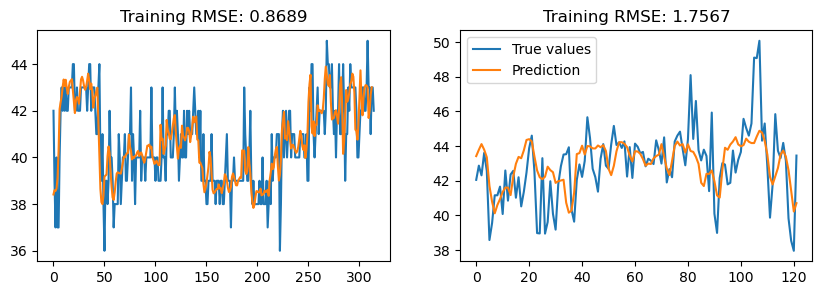

In [47]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
axes[0].plot(y_train, label='True values')
axes[0].plot(ytr_pred, label='Prediction')
axes[0].set_title(f'Training RMSE: {rmse_tr:.4f}')
axes[1].plot(y_test, label='True values')
axes[1].plot(yte_pred, label='Prediction')
axes[1].set_title(f'Training RMSE: {rmse_te:.4f}')
plt.legend()